In [22]:
!apt-get install -y poppler-utils

from google.colab import drive
drive.mount('/content/drive')





Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
dataset_path = "/content/drive/MyDrive/USA currency"


In [24]:
# Import required libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import imghdr
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.utils import shuffle
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [25]:
data_dir = '/content/drive/MyDrive/USA currency'
image_exts = ['jpeg', 'jpg', 'png']

# Print the names of the subfolders (classes)
for image_class in os.listdir(data_dir):
    print(image_class)


.DS_Store
10 Dollar
1 Dollar
5 Dollar
100 Dollar
50 Dollar
2 Dollar
Test
Model


In [26]:
# Remove images not matching allowed extensions and remove ICC profiles
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    # Skip non-directory files (e.g., .DS_Store)
    if not os.path.isdir(class_path):
        continue
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        try:
            # Check with cv2 and imghdr
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image not in ext list: {image_path}')
                os.remove(image_path)
            else:
                # Remove ICC profile using PIL
                with Image.open(image_path) as im_obj:
                    im_obj.info.pop('icc_profile', None)
                    im_obj.save(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}: {e}')
            os.remove(image_path)



In [27]:
# Load and Process Images
# ---------------------------
X = []  # list for images
Z = []  # list for labels

# Define your image size
img_size = 224



In [28]:
# Define directories for each currency class
One_Dollar_dir    = '/content/drive/MyDrive/USA currency/1 Dollar'
Ten_Dollar_dir    = '/content/drive/MyDrive/USA currency/10 Dollar'
Hundred_Dollar_dir= '/content/drive/MyDrive/USA currency/100 Dollar'
Two_Dollar_dir    = '/content/drive/MyDrive/USA currency/2 Dollar'
Five_Dollar_dir   = '/content/drive/MyDrive/USA currency/5 Dollar'
Fifty_Dollar_dir  = '/content/drive/MyDrive/USA currency/50 Dollar'

# Simple function to assign label (here we just return the provided currency_type)
def assign_label(img, currency_type):
    return currency_type

# Function to read images from a directory, resize, and append data and labels to lists
def make_train_data(currency_type, directory):
    for img_name in tqdm(os.listdir(directory), desc=f"Processing {currency_type}"):
        label = assign_label(img_name, currency_type)
        path = os.path.join(directory, img_name)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        X.append(np.array(img))
        Z.append(label)



In [29]:
# Process each class (using names matching your folder names)
make_train_data('1 Dollar', One_Dollar_dir)
make_train_data('10 Dollar', Ten_Dollar_dir)
make_train_data('100 Dollar', Hundred_Dollar_dir)
make_train_data('2 Dollar', Two_Dollar_dir)
make_train_data('5 Dollar', Five_Dollar_dir)
make_train_data('50 Dollar', Fifty_Dollar_dir)

print("\nTotal images loaded:", len(X))


Processing 50 Dollar: 100%|██████████| 685/685 [00:09<00:00, 69.66it/s]


Total images loaded: 3906


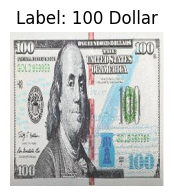

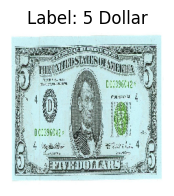

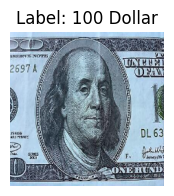

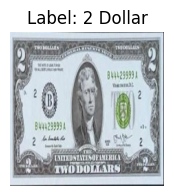

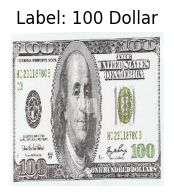

In [30]:
# Shuffle the data
X, Z = shuffle(X, Z, random_state=42)

# Display a few images with their labels
for i in range(5):
    plt.figure(figsize=(2,2))
    plt.imshow(X[i])
    plt.title(f"Label: {Z[i]}")
    plt.axis('off')
    plt.show()


In [31]:
# Normalize the images (convert to float and scale between 0 and 1)
def normalize_images(X):
    return np.array(X, dtype="float32") / 255.0

X = normalize_images(X)

# Convert labels to numeric values and then one-hot encode
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=6)
print(f"Total number of images after processing: {len(X)}")


Total number of images after processing: 3906


In [32]:
# Split the Data into Training, Validation, and Test Sets
# ---------------------------
# 70% train, 30% temporary set
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
# From the temporary set: 1/3 test and 2/3 validation -> ~10% test, ~20% validation overall
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=1/3, random_state=42)

print(f"Number of training images: {len(X_train)}")
print(f"Number of validation images: {len(X_val)}")
print(f"Number of test images: {len(X_test)}")


Number of training images: 2734
Number of validation images: 781
Number of test images: 391


In [33]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False

num_classes = 6

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)


In [35]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy'
    patience=10,              # stop if no improvement after 10 epochs
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,               # reduce learning rate by a factor of 0.2
    patience=5,               # wait 5 epochs before reducing LR
    min_lr=1e-7
)

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,692,038 (98.01 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 45s 314ms/step - accuracy: 0.1915 - loss: 13.8404 - val_accuracy: 0.2894 - val_loss: 9.5085 - learning_rate: 1.0000e-04
Epoch 2/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.2477 - loss: 8.5734 - val_accuracy: 0.3521 - val_loss: 6.0722 - learning_rate: 1.0000e-04
Epoch 3/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.3016 - loss: 5.5710 - val_accuracy: 0.3585 - val_loss: 4.1363 - learning_rate: 1.0000e-04
Epoch 4/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.3415 - loss: 3.8635 - val_accuracy: 0.3611 - val_loss: 3.0773 - learning_rate: 1.0000e-04
Epoch 5/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.3995 - loss: 2.9358 - val_accuracy: 0.5416 - val_loss: 2.4677 - learning_rate: 1.0000e-04
Epoch 6/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.4391 - loss: 2.4141 - val_accuracy: 0.5659 - val_loss: 2.1673 - learning_rate: 1.0000e-04
Epoch 7/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/st

In [36]:
def plot_history(history):
    plt.figure(figsize=(14, 6))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Val Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


In [37]:
# Evaluate the Model on the Test Set
# ---------------------------
def evaluate_model(model, X_test, Y_test):
    # Convert one-hot encoded Y_test to class labels
    Y_test_classes = np.argmax(Y_test, axis=1)
    # Make predictions
    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    # Define class names (the sorted order from LabelEncoder)
    class_names = le.classes_  # This will be in sorted order (e.g., ['1 Dollar', '10 Dollar', ...])
    print("Classification Report:")
    print(classification_report(Y_test_classes, Y_pred_classes, target_names=class_names))

    # Confusion Matrix
    conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step
Classification Report:
              precision    recall  f1-score   support

    1 Dollar       0.80      0.93      0.86        57
   10 Dollar       0.87      0.89      0.88        81
  100 Dollar       0.93      0.86      0.89        63
    2 Dollar       0.89      0.92      0.90        61
    5 Dollar       1.00      0.83      0.91        65
   50 Dollar       0.79      0.83      0.81        64

    accuracy                           0.87       391
   macro avg       0.88      0.88      0.88       391
weighted avg       0.88      0.87      0.88       391



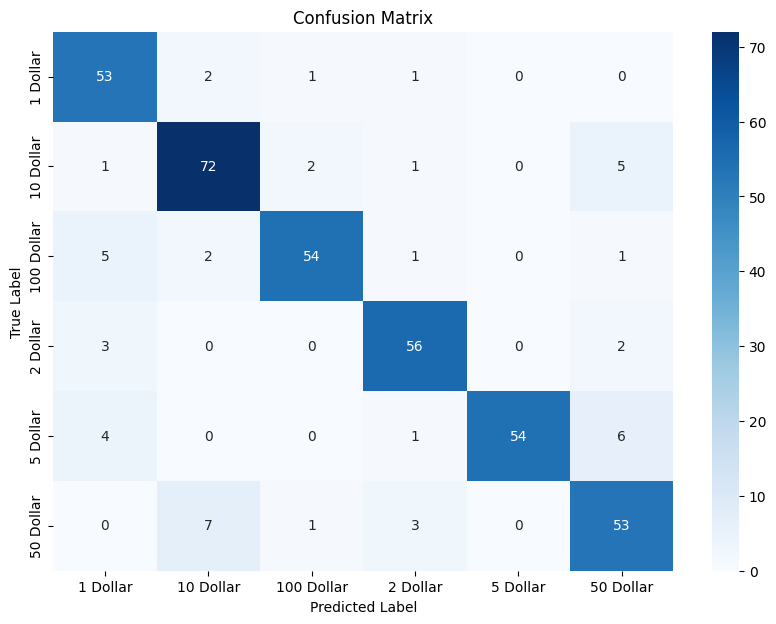

In [38]:
evaluate_model(model, X_test, Y_test)

from keras.preprocessing import image

In [39]:
test_dir = '/content/drive/MyDrive/USA currency/Test'

# List image files (png and jpg)
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


In [40]:
label_map = {}
for idx, label in enumerate(le.classes_):
    label_map[idx] = f"{label} Bill"

# Process each image file in the test directory
for img_file in image_files:
    img_path = os.path.join(test_dir, img_file)
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


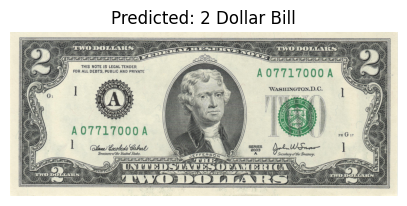

In [41]:
# Predict
prediction = model.predict(img_array)
label_idx = np.argmax(prediction)
predicted_label = label_map[label_idx]

    # Display the image with prediction
plt.figure(figsize=(5,5))
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

In [42]:
model_save_path = '/content/drive/MyDrive/USA currency/Model/currency_model.keras'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/USA currency/Model/currency_model.keras


In [43]:
import tensorflow as tf

# Load your .keras model from Drive
model = tf.keras.models.load_model('/content/drive/MyDrive/USA currency/Model/currency_model.keras')

# (Optional) Display model summary to confirm it loaded correctly
model.summary()

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite file back to Drive
with open('/content/drive/MyDrive/currency_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted and saved to Drive as currency_model.tflite")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 29,900,692 (114.06 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,208,654 (16.05 MB)

Saved artifact at '/tmp/tmp7odamdch'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  137147328289424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137147328285968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137147328283088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137147328292112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137147328289616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137147328290576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137147328288464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137147328287696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137147328283856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137147328286352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1371473282903